# Simple Stitching of 3 SEM Images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def compare(images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    images : dict
        Images to display with keys as labels
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    
    if not isinstance(images, dict):
        images = {k: v for k, v in zip(range(len(images)), images)}

    for n, (label, img) in enumerate(images.items()):
        axes[n].imshow(img)
        axes[n].set_title(label)
        axes[n].axis('off')

    f.tight_layout()

---
## Load image data
Use tifffile package for unpacking multi-page tiff files and display images

In [2]:
from glob import glob
import tifffile

def load_tiff(tiff_file):
    ome_dict = {}
    with tifffile.TiffFile(ome_file) as tif:
        for p, page in enumerate(tif):
            if page.tags['page_name'].value == b'Composited image':
                ome_dict['FM'] = page
            elif page.tags['page_name'].value == b'Secondary electrons':
                ome_dict['EM'] = page
            else:
                ome_dict['?M'] = page
    return ome_dict

ome_files = sorted(glob('test*.ome.tiff'))
im_dict = {}

for ome_file in ome_files:
    k = ome_file.split('.')[0]
    im_dict[k] = load_tiff(ome_file)

In [3]:
EM_imgs = {}
FM_imgs = {}

for k, d in im_dict.items():
    EM_imgs[k] = d['EM'].asarray()
    FM_imgs[k] = d['FM'].asarray()

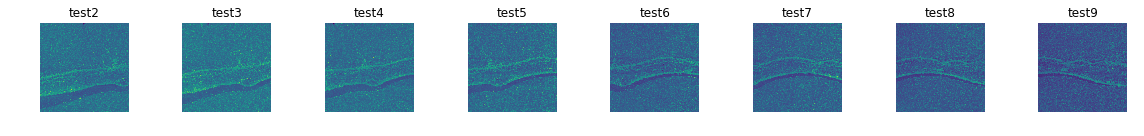

In [4]:
compare(EM_imgs, figsize=(16, 6))

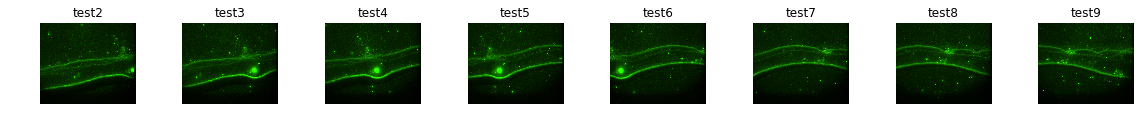

In [5]:
compare(FM_imgs, figsize=(16, 6))

---
## Preprocessing Data
Choose just 3 images and convert to grayscale

In [6]:
from skimage.color import rgb2gray

# Make grayscale versions of three color images from FM_imgs
FM_0 = rgb2gray(FM_imgs['test3'])
FM_1 = rgb2gray(FM_imgs['test5'])
FM_2 = rgb2gray(FM_imgs['test7'])

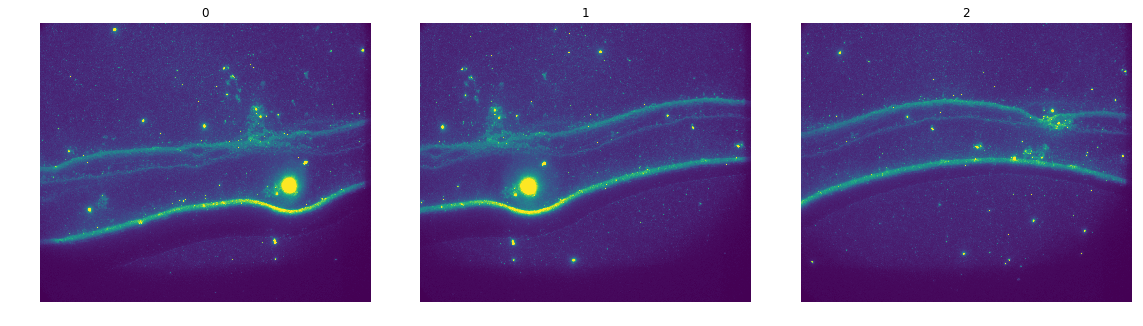

In [7]:
compare([FM_0, FM_1, FM_2], figsize=(16, 6))

---
## Feature detection and matching
Estimate a projective transformation that relates the FM images together.

* Define center image as the target image, which will remain anchored while the others are warped
* Detect features in all three images using "Oriented FAST and rotated BRIEF" (`ORB`) method
* Match features from left and right images against the features in the center, anchored image

**Note**: For efficiency, 800 keypoints are used for `ORB`. The results are good but small variations are expected. To determine a more robust estimate, run multiple times and pick the best result or generate additional keypoints.

In [8]:
from skimage.feature import ORB
from skimage.feature import match_descriptors

# Initialize ORB
# This number of keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in FM_0
orb.detect_and_extract(FM_0)
kps0 = orb.keypoints
dps0 = orb.descriptors

# Detect keypoints in FM_1
orb.detect_and_extract(FM_1)
kps1 = orb.keypoints
dps1 = orb.descriptors

# Detect keypoints in FM_2
orb.detect_and_extract(FM_2)
kps2 = orb.keypoints
dps2 = orb.descriptors

# Match features
matches01 = match_descriptors(dps0, dps1, cross_check=True)
matches12 = match_descriptors(dps1, dps2, cross_check=True)

---
Inspect the matches found by ORB side-by-side

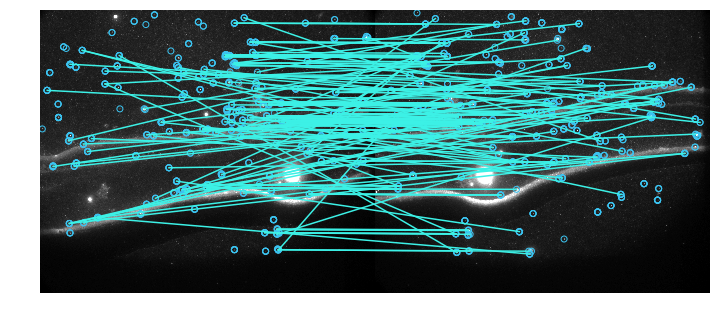

In [9]:
from skimage.feature import plot_matches

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_matches(ax, FM_0, FM_1, kps0, kps1, matches01, '#3CC4F1', '#3CF1E6')
ax.axis('off');

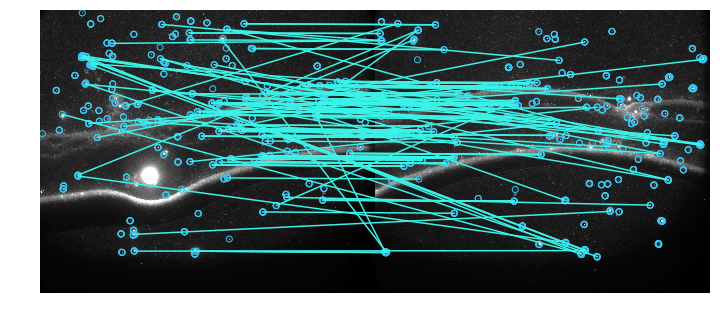

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_matches(ax, FM_1, FM_2, kps1, kps2, matches12, '#3CC4F1', '#3CF1E6')
ax.axis('off');

---
## Estimate Transformation

Use RANdom SAmple Consensus (RANSAC), an outlier rejector, to remove false matches

In [11]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from
#   * source (image to be registered): FM_0
#   * target (reference image): FM_1
src = kps0[matches01[:, 0]][:, ::-1]
dst = kps1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from
#   * source (image to be registered): FM_0
#   * target (reference image): FM_1
src = kps2[matches12[:, 1]][:, ::-1]
dst = kps1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

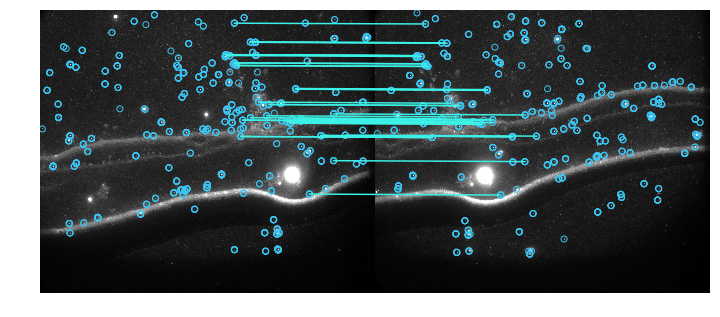

In [12]:
# Check results of RANSAC
# Use plot_matches as before but now indexing on only RANSAC approved matches
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_matches(ax, FM_0, FM_1, kps0, kps1, matches01[inliers01], '#3CC4F1', '#3CF1E6')
ax.axis('off');

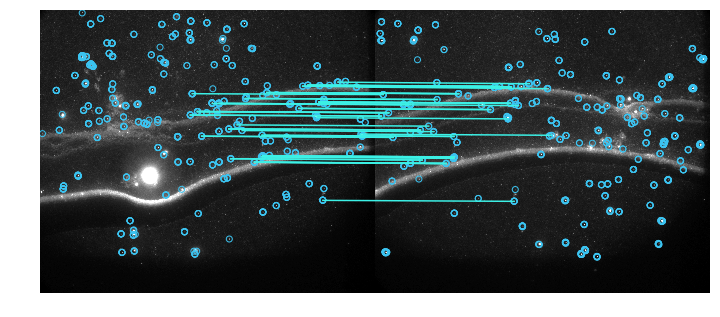

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_matches(ax, FM_1, FM_2, kps1, kps2, matches12[inliers12], '#3CC4F1', '#3CF1E6')
ax.axis('off');

---
## Adjust the Image Extent

In [14]:
from skimage.transform import SimilarityTransform

# Shape of middle image, the registration target
r, c = FM_1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

## Apply Estimated Transforms

"Warp" the images with `skimage.transform.warp` according to the estimated models

**Notes**:
* Values outside the input images are initially set to -1 to distinguish the "background", which is identified for later use.
* Warp takes the inverse mapping as an input.

In [15]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation=-corner_min)

# Translate pano1 into place
FM_1_warped = warp(FM_1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
FM_1_mask = (FM_1_warped != -1)  # Mask == 1 inside image
FM_1_warped[~FM_1_mask] = 0      # Return background values to 0


# Warp FM_0 to FM_1
transform01 = (model_robust01 + offset1).inverse
FM_0_warped = warp(FM_0, transform01, order=3,
                   output_shape=output_shape, cval=-1)

FM_0_mask = (FM_0_warped != -1)  # Mask == 1 inside image
FM_0_warped[~FM_0_mask] = 0      # Return background values to 0


# Warp pano2 to pano1
transform12 = (model_robust12 + offset1).inverse
FM_2_warped = warp(FM_2, transform12, order=3,
                   output_shape=output_shape, cval=-1)

FM_2_mask = (FM_2_warped != -1)  # Mask == 1 inside image
FM_2_warped[~FM_2_mask] = 0      # Return background values to 0

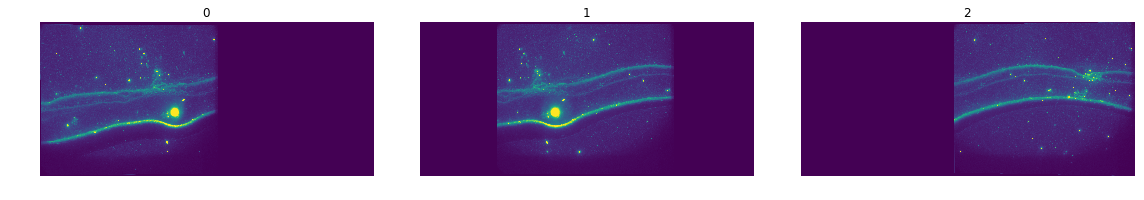

In [16]:
compare([FM_0_warped, FM_1_warped, FM_2_warped], figsize=(16, 6));

---
## Crudely Combine Images

This method simply
* Sums the warped images
* Tracks how many images overlapped to create each point
* Normalizes the result

In [17]:
# Add the three warped images together
merged = FM_0_warped + FM_1_warped + FM_2_warped ## Sum warped images

# Track the overlap by adding the masks together
overlap = FM_0_mask.astype(int) + FM_1_mask.astype(int) + FM_2_mask.astype(int) ## Sum masks

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / (overlap + 1)

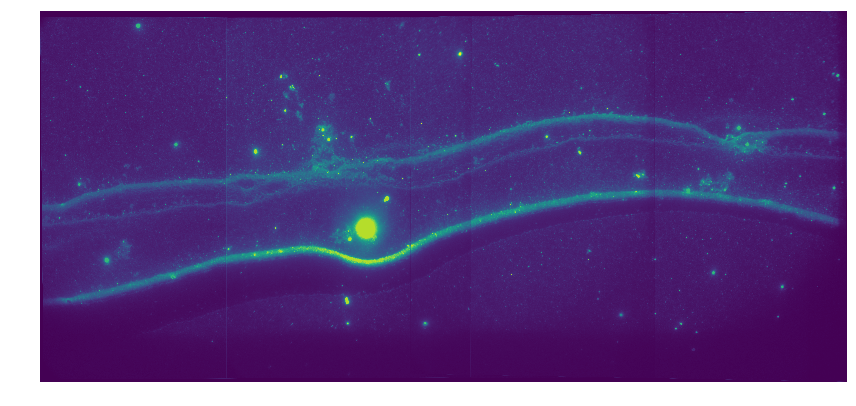

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized)

fig.tight_layout()
ax.axis('off');

---
## Properly Combine Images

Stitching images together along a **minimum-cost path** and **`skimage.graph`**

Among other things, `skimage.graph` allows you to
* Start at any point on an array
* Find the path to any other point in the array
* The path found minimizes the sum of values on the path

The array is called a cost array, while the path found is a minimum-cost path or MCP. To accomplish this we need
* Starting and ending points for the path (seed points)
* A cost array (a modified difference image)

This method is so powerful that, with a carefully constructed cost array, the seed points are essentially irrelevant

### Define seed points

In [19]:
# Define seed points
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

### Construct cost array

This utility function gives a "cost break" for paths from the edge to the overlap region

In [20]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : (M, N) ndarray of floats
        Difference of two overlapping images.
    mask : (M, N) ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : (M, N) ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

In [21]:
# Generate the cost array
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(FM_0_warped - FM_1_warped),
                         FM_0_mask & FM_1_mask)

# Allow the path to "slide" along top and bottom edges 
# to the optimal horizontal position by setting top and 
# bottom edges to zero cost
costs01[0, :] = 0
costs01[-1, :] = 0

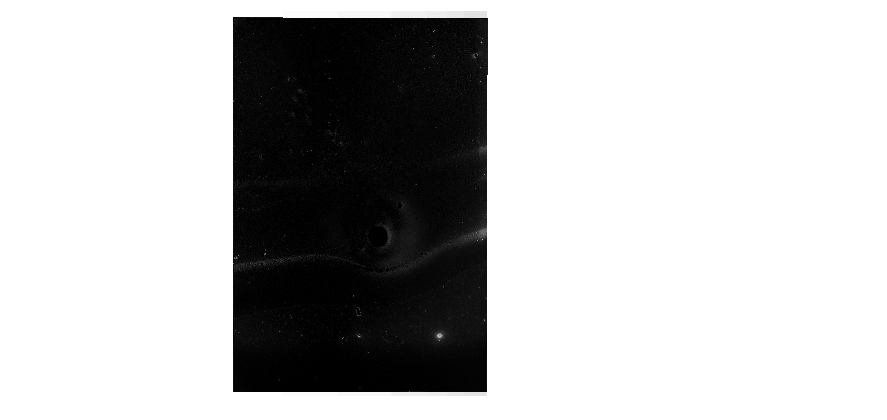

In [22]:
# Display cost array
fig, ax = plt.subplots(figsize=(15, 12))
ax.imshow(costs01, cmap='gray', interpolation='none')
ax.axis('off');

### Find the minimum-cost path (MCP)
Use `skimage.graph.route_through_array` to find an optimal path through the cost array

In [23]:
from skimage.graph import route_through_array

# Arguments are: cost array, start pt, end pt, can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

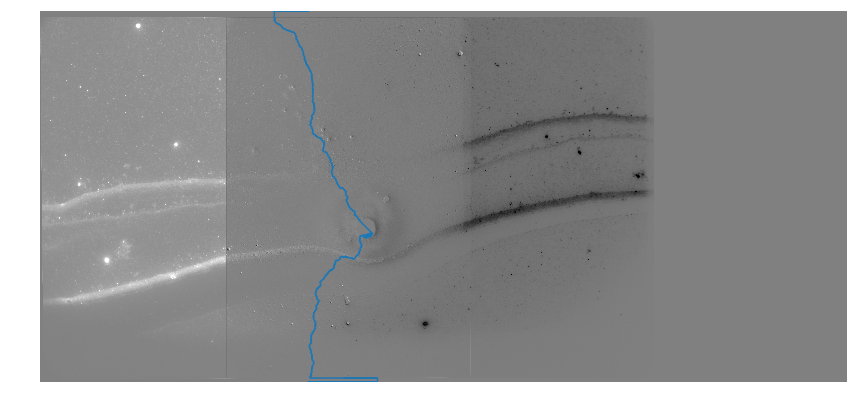

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(FM_0_warped - FM_1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

### Filling the mask

Turn path into a mask, which will be 1 where we want the left image to show through and zero elsewhere

In [25]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(FM_0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

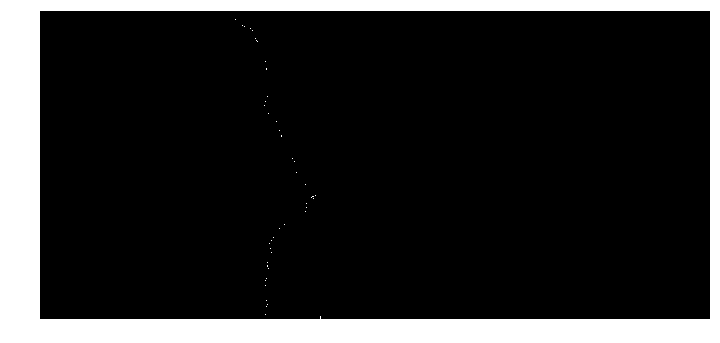

In [26]:
# View the path in black and white
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(mask0, cmap='gray')
ax.axis('off');

Label the various contiguous regions in the image using skimage.measure.label

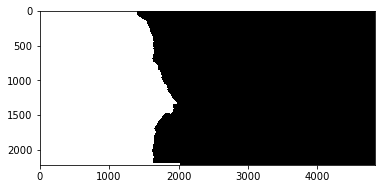

In [27]:
from skimage.measure import label

# Labeling starts with zero at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# The result
plt.imshow(mask0, cmap='gray');

Reat for FM images 1 & 2, this time adding an additional constraint preventing the paths from crossing one another

In [28]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs
costs12 = generate_costs(np.abs(FM_1_warped - FM_2_warped),
                         FM_1_mask & FM_2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

# Add additional constraint to prevent crossing
costs12[mask0 > 0] = 1

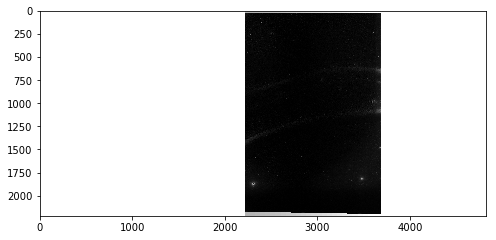

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

In [30]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

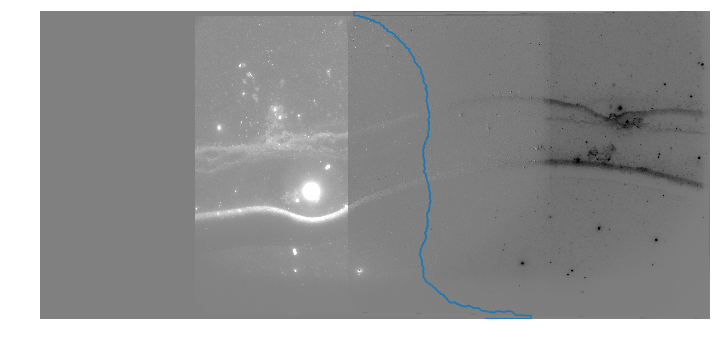

In [31]:
# Plot the difference image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(FM_1_warped - FM_2_warped, cmap='gray')
# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);
ax.axis('off');

In [32]:
# Initialize the mask by placing the path in a new array
mask2 = np.zeros_like(FM_0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

#Fill the right side this time, again using skimage.measure.label - the label of interest is 3
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

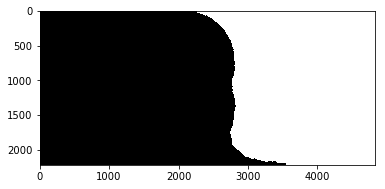

In [33]:
# The result
plt.imshow(mask2, cmap='gray');

### Make the final mask
The last mask for the middle image is one of exclusion - it will be displayed everywhere mask0 and mask2 are not

In [34]:
mask1 = ~(mask0 | mask2).astype(bool)

In [35]:
# Define a convenience function to place masks in alpha channels
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

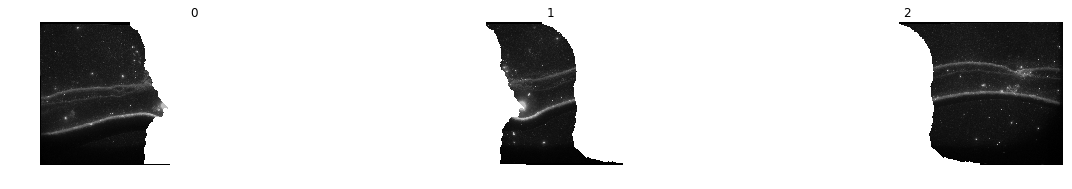

In [36]:
# Obtain final, alpha blended individual images and inspect them
FM_0_final = add_alpha(FM_0_warped, mask0)
FM_1_final = add_alpha(FM_1_warped, mask1)
FM_2_final = add_alpha(FM_2_warped, mask2)

compare([FM_0_final, FM_1_final, FM_2_final], figsize=(15, 15));

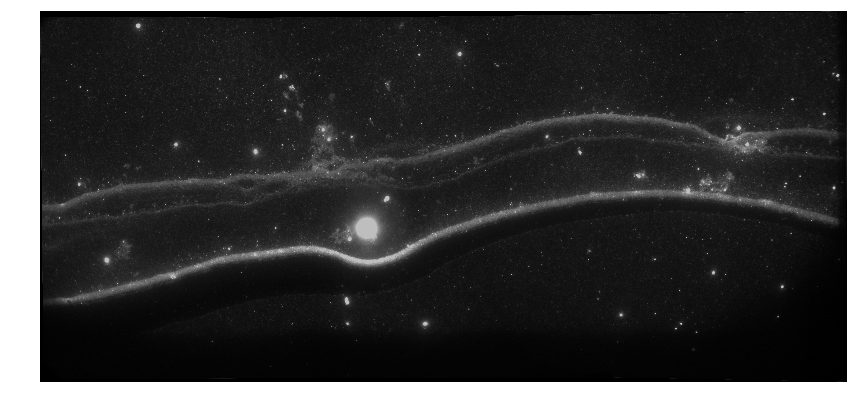

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(FM_0_final, interpolation='none')
ax.imshow(FM_1_final, interpolation='none')
ax.imshow(FM_2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');